In [1]:
import cnot_network

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sbs
import numpy as np
sbs.set_context("paper")
sbs.set_theme()
sbs.set_style("dark")

from surface_code_routing.tikz_utils import tikz, tex

sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

def plt_data(condition, x_axis, y_axis, target=None):
    data = filter(lambda x: x[0] == target, zip(condition, x_axis, y_axis))
    x = []
    y = []
    for _, x_val, y_val in data:
        x.append(x_val)
        y.append(y_val)
    return {'x':x, 'y':y}

def plt_data_multi(data, x_axis, y_axis, **targets):
    idx_map = {j:i for i, j in enumerate(data)}
    rev_map = {j:i for i, j in idx_map.items()}

    iters = zip(*[iter(data[rev_map[i]]) for i, _ in enumerate(data)])

    x = []
    y = []
    for it in iters:
        checks = True
        for targ in targets:
            if it[idx_map[targ]] != targets[targ]:
                checks = False
        if not checks:
            continue
            
        x.append(it[idx_map[x_axis]])
        y.append(it[idx_map[y_axis]])
    return {'x':x, 'y':y}

In [2]:
from surface_code_routing.dag import DAG
from surface_code_routing.symbol import Symbol 
from surface_code_routing.instructions import INIT, CNOT, MEAS, X, Hadamard, SWAP
from surface_code_routing.lib_instructions import T_Factory, CSWAP
from surface_code_routing.compiled_qcb import compile_qcb

In [3]:
import cnot_network
from functools import partial
from surface_code_routing.lib_instructions import T_Factory, Toffoli, T_gate

toff_height = 14
toff_width = toff_height

t_factory_l1 = cnot_network.T_Factory()
toffoli_gate = cnot_network.Toffoli

t_factory_l2 = T_Factory(t_factory_l1, height=8, width=10, t_gate=T_gate(t_factory_l1))
t_gate_l2 = T_gate(factory=t_factory_l2)

t_factory_l3 = T_Factory(t_factory_l2, height=11, width=12, t_gate=T_gate(t_factory_l2))
t_gate_l3 = T_gate(factory=t_factory_l3)

extern_toffoli_l1 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l1)
extern_toffoli_l2 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l2)
extern_toffoli_l3 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l3)

# Raw T injection sites
ccz_factory_l1 = cnot_network.CCZ_factory(6, 4, t_factory=None)
ccz_factory_l2 = cnot_network.CCZ_factory(9, 7, t_factory=t_factory_l1)
ccz_factory_l3 = cnot_network.CCZ_factory(11, 11, t_factory=t_factory_l2)

t_factories = (t_factory_l1, t_factory_l2, t_factory_l3)
extern_toffolis = (extern_toffoli_l1, extern_toffoli_l2, extern_toffoli_l3)
ccz_factories = (ccz_factory_l1, ccz_factory_l2, ccz_factory_l3)

In [4]:
toffoli = partial(Toffoli, T=T_gate(factory=t_factory_l1))

toffoli = cnot_network.toff_extern(extern_toffoli_l1)

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

In [5]:
def BB(*externs, height=32, width=32, CSWAP=CSWAP, **compiler_arguments):
    '''
    Base Bucket Brigade Object
    '''
    registers = ('ctrl', 'route', 'targ_0', 'targ_1')
    dag = DAG(Symbol('BB', registers, registers))

    dag.add_gate(X(f'ctrl'))
    dag.add_gate(CSWAP(f'ctrl', f'route', f'targ_0'))
    dag.add_gate(X(f'ctrl'))
    dag.add_gate(CSWAP(f'ctrl', f'route', f'targ_1'))

    return compile_qcb(dag, height, width, *externs, **compiler_arguments)

In [6]:
factory = ccz_factory_l1

ccz_toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=factory)
cswap = partial(CSWAP, Toffoli=ccz_toffoli_gate)

height = 10
width = 14

while True:
    try:
        bb = BB(factory, CSWAP=cswap, height=height, width=width)
        while len(bb.dag.physical_externs) < 3: # Rebake until we get something good
            print('\rBB1:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')
            bb = BB(factory, CSWAP=cswap, height=height, width=width)
        break
    except:
        continue
print('\r# BB1:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')

bb_1 = bb
print()

height = 12
width = 14
factory = ccz_factory_l2

bb = BB(factory, CSWAP=cswap, height=height, width=width)
while len(bb.dag.physical_externs) < 2: # Rebake until we get something good
    print('\rBB2:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')
    bb = BB(factory, CSWAP=cswap, height=height, width=width)
print('\r# BB2:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')

bb_2 = bb
print()

height = 38
width = 14
factory = ccz_factory_l3

bb = BB(factory, CSWAP=cswap, height=height, width=width)
while len(bb.dag.physical_externs) < 3: # Rebake until we get something good
    print('\rBB3:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')
    bb = BB(factory, CSWAP=cswap, height=height, width=width, allocator_kwargs={'over_allocate': True})
print('\r# BB3:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')

bb_3 = bb

bbs = (bb_1, bb_2, bb_3)

# BB1: 3 1092 40           
# BB2: 2 29433 480           
# BB3: 3 712228 4680           

In [6]:
repeats = 10
results = {'distillation':[], 'height':[], 'runtime':[], 'volume':[], 'delay':[], 'externs':[]}

ccz_toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)
cswap = partial(CSWAP, Toffoli=ccz_toffoli_gate)

for distillation, factory in zip((1, 2, 3), ccz_factories):
    for i in range(14, 40):
        print(f"\rCompiling: {distillation} : {i}" + " " * 5, end='', flush=True)
        for _ in range(repeats):
            qcb = BB(factory, CSWAP=cswap, height=i, width=i)
            results['distillation'].append(distillation)        
            results['height'].append(i)
            results['runtime'].append(qcb.n_cycles())
            results['volume'].append(qcb.space_time_volume())
            results['externs'].append(len(qcb.dag.physical_externs))
results_bb = results

Compiling: 3 : 39     

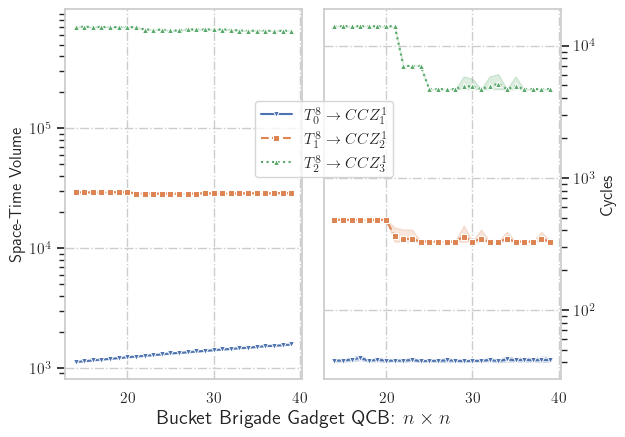

In [8]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


marks = ['v', 's', '^', '*']
linestyles = ['-', '--', ':']

filter_target = 'distillation'
dependent = 'volume'
independent = 'height'

res = results_bb

#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 4), (0, 0), colspan=2),
    plt.subplot2grid((1, 4), (0, 2), colspan=2)
]
fig = plt.gcf()


subplot = ax[0]
for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data(
            res[filter_target],
            res[independent],
            res[dependent],
            target=target
        ),
        label=f'BB$_{{CCZ_{target}}}$',
        linestyle=linestyles[idx],
        markersize = 5,
        marker=marks[idx],
        errorbar=('ci', 100)
    )

subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'
subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data(
            res[filter_target],
            res[independent],
            res[dependent],
            target=target
        ),
        label=f'$T^{8}_{{{target - 1}}} \\rightarrow CCZ^1_{{{target}}}$',
        linestyle=linestyles[idx],
        markersize = 5,
        marker=marks[idx],
        errorbar=('ci', 100)
    )

subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.41, 0.705))

fig.supxlabel('Bucket Brigade Gadget QCB: $n \\times n$')


#sbs.lineplot(x=results_extern['n_ctrl'], y=results_extern['volume'], label="Toffoli Extern")
#sbs.lineplot(x=results_ccz['n_ctrl'], y=results_ccz['volume'], label='Toffoli Factory', **ccz_style, marker='^')


#plt.title('Toffoli Runtimes for Various QCB Sizes')
#plt.xlabel('C$^{n}$X')
#plt.ylabel('Space-Time Volume')

#plt.yscale('log')

#plt.legend()

#plt.savefig('bb.pdf')

In [33]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


marks = ['v', 's', '^', '*']
linestyles = ['-', '--', ':']

filter_target = 'distillation'
dependent = 'volume'
independent = 'height'

res = results_bb

#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 4), (0, 0), colspan=2),
    plt.subplot2grid((1, 4), (0, 2), colspan=2)
]
fig = plt.gcf()


subplot = ax[0]
for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data_multi(
            res,
            independent,
            dependent,
            distillation=target
        ),
        label=f'BB$_{{CCZ_{target}}}$',
        linestyle=linestyles[idx],
        markersize = 5,
        marker=marks[idx],
        errorbar=('ci', 100)
    )

subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'
subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data(
            res[filter_target],
            res[independent],
            res[dependent],
            target=target
        ),
        label=f'$T^{8}_{{{target - 1}}} \\rightarrow CCZ^1_{{{target}}}$',
        linestyle=linestyles[idx],
        markersize = 5,
        marker=marks[idx],
                errorbar=('ci', 100)

    )

subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.41, 0.705))

fig.supxlabel('Bucket Brigade Gadget QCB: $n \\times n$')




#sbs.lineplot(x=results_extern['n_ctrl'], y=results_extern['volume'], label="Toffoli Extern")
#sbs.lineplot(x=results_ccz['n_ctrl'], y=results_ccz['volume'], label='Toffoli Factory', **ccz_style, marker='^')


#plt.title('Toffoli Runtimes for Various QCB Sizes')
#plt.xlabel('C$^{n}$X')
#plt.ylabel('Space-Time Volume')

#plt.yscale('log')

#plt.legend()

#plt.savefig('bb_gadget.pdf')

NameError: name 'results_bb' is not defined

In [13]:
results = {'distillation':[], 'address_size': [], 'line_width':[], 'height':[], 'runtime':[], 'volume':[]}

repeats = 5

for distillation, ccz_factory in zip((1,), ccz_factories):
    ccz_toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory)

    bb = BB(ccz_factory, CSWAP=cswap, height=10, width=14)
    while len(bb.dag.physical_externs) < 3: # Rebake until we get something good
        bb = BB(ccz_factory, CSWAP=cswap, height=10, width=14)
    
    for i in range(1, 10):
        for j in range(1, 4):
            for _ in range(repeats):
                #try:
                    print(f"\rCompiling: {distillation} : {i} {j}" + " " * 5, end='', flush=True)
                    qcb = bucket_brigade_gadget(i, j, 48, 48, BB=bb)
                    results['distillation'].append(distillation)
                    results['address_size'].append(i)
                    results['line_width'].append(j)
                
                    results['height'].append(qcb_size)
                    results['runtime'].append(qcb.n_cycles())
                    results['volume'].append(qcb.space_time_volume())
                #except:
                #    pass

results_bb_gadget = results

Compiling: 1 : 1 1     

NameError: name 'bucket_brigade_gadget' is not defined

In [38]:
results_ccz = {
    'distillation': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'address_size': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7], 'line_width': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 1, 1, 2, 2, 2, 1], 'height': [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32], 'runtime': [189, 189, 189, 189, 189, 298, 298, 298, 297, 297, 776, 406, 406, 405, 407, 668, 226, 668, 226, 363, 381, 381, 996, 525, 525, 488, 687, 1316, 1320, 1318, 478, 686, 477, 687, 382, 1010, 694, 1010, 543, 455, 2616, 706, 1336, 2620, 587, 1388, 747, 468, 743, 1389, 1083, 2090, 1085, 2090, 2090, 2792, 2792, 2792, 2799, 2794, 2846, 1930, 1929, 1928, 1928, 2235, 2945, 2937, 2939, 2947, 2988, 11684, 2960, 11576, 6055, 17956, 9009, 23584], 'volume': [17904, 17898, 17834, 17890, 17892, 29829, 29607, 29524, 30014, 29913, 69245, 46441, 45800, 46463, 45196, 48159, 35080, 48025, 35217, 38190, 55276, 54946, 93412, 60779, 60780, 84253, 99050, 150953, 149003, 148886, 79078, 93339, 78339, 92844, 68433, 175795, 140462, 177695, 122987, 115477, 426882, 199718, 283191, 401374, 182634, 248052, 186582, 154013, 186522, 247360, 337873, 510962, 341079, 499762, 496943, 818312, 821745, 816711, 841380, 828206, 724932, 585676, 592030, 588308, 587831, 1026385, 1211552, 1199461, 1229774, 1236491, 1723018, 5383133, 1495469, 4616113, 4060483, 10852337, 5541468, 16514228]
}

NameError: name 'plt_data_multi' is not defined

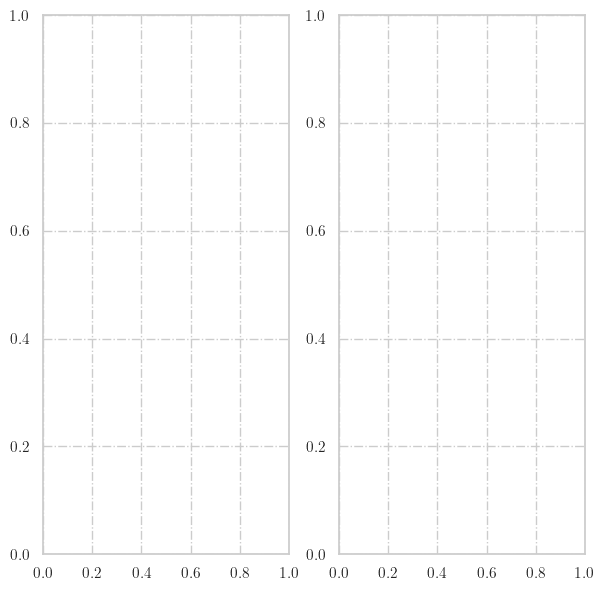

In [17]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


marks = ['', '.', 'x', '*']
linestyles = ['-', '--', ':']

filter_target = 'line_width'
dependent = 'volume'
independent = 'address_size'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

subplot = ax[0]

for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data_multi(
            results_ccz,
            independent,
            dependent,
            distillation=target
        ),
        label=f'CCZ$_{target}$',
        linestyle=linestyles[idx],
        marker='v',
        color=sbs.color_palette()[2]
    )
    
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'
subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data_multi(
            results_ccz,
            independent,
            dependent,
            distillation=target
        ),
        label=f'CCZ$_{target}$',
        linestyle=linestyles[idx],
        marker='v',
        color=sbs.color_palette()[2]
    )
    
    
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')


fig.supxlabel('QRAM Address Size')
subplot.set_ylabel('Cycles')




#sbs.lineplot(x=results_extern['n_ctrl'], y=results_extern['volume'], label="Toffoli Extern")
#sbs.lineplot(x=results_ccz['n_ctrl'], y=results_ccz['volume'], label='Toffoli Factory', **ccz_style, marker='^')


#plt.title('Toffoli Runtimes for Various QCB Sizes')
#plt.xlabel('C$^{n}$X')
#plt.ylabel('Space-Time Volume')

#plt.yscale('log')

#plt.legend()

#plt.savefig('multi_toffoli.pdf')

In [7]:
def bucket_brigade_gadget(address_size, line_width, width, height, *externs, compile=True, readout=CNOT, BB=None, **compiler_args):
    def bb(*args):
        dag = BB.instruction(args=args, targs=args)
        return dag
         
    dag = DAG(Symbol('qram_bucket_brigade', ['query_{i}'.format(i=i) for i in range(address_size)] , ['readout_{i}'.format(i=i) for i in range(line_width)]))

    int_to_bin = lambda x: bin(x)[2:]


    #print("FANOUT")
    for target_anc in range(line_width):
        anc = int_to_bin(target_anc)
        dag.add_gate(INIT(f'route_root_{anc}'))
    dag.add_gate(INIT(f'ctrl_root'))

        layer = int_to_bin(layer)
    for layer in range(1 << (address_size - 1)):
        dag.add_gate(INIT(f'ctrl_{layer}'))

        for anc in range(line_width):
            dag.add_gate(INIT(f'route_{layer}_{anc}'))

    for layer in range(1 << address_size):
        layer = int_to_bin(layer)
        for addr in range(line_width):
            dag.add_gate(INIT(f'mem_{layer}_{addr}'))


    # Build routing network
    for i in range(address_size):

        dag.add_gate(SWAP(f'query_{i}', f'ctrl_root'))
        if i > 0:
            dag.add_gate(bb(f'ctrl_root', 'route_root', 'route_0_0', 'route_1_0'))
            #print('\t','ROUTE ROOT', i, f'ctrl_root', f'route_root', f'route_1_0')
        else:
            dag.add_gate(SWAP(f'query_{i}', f'ctrl_root'))
            dag.add_gate(bb(f'ctrl_root', 'route_root', 'route_0_0', 'route_1_0'))
            continue

        # Route previous layers
        for layer in range(i - 1):
            if layer > 0:
                for last_layer in range(1 << (layer - 1)):
                    last_layer = int_to_bin(last_layer)
                    dag.add_gate(bb(f'ctrl_{last_layer}', f'route_{last_layer}_0', f'route_{last_layer}0_0', f'route_{last_layer}1_0)'))


        # Control current layer
        for last_layer in range(1 << (i - 1)):
            addr = int_to_bin(last_layer)
            dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_0', f'ctrl_{addr}0', f'ctrl_{addr}0)'))
            #print('\t','CTRL', i, addr , f'ctrl_{addr}', f'route_{addr}', f'ctrl_{addr}1')

    # Readout
    #print("READOUT")
    for i in range(1 << (address_size - 1)):
        addr = int_to_bin(i).zfill(address_size - 1)
        for idx in range(line_width):
            dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_{idx}', f'mem_{addr}0_{idx}', f'mem_{addr}1_{idx})'))


            #print('\t','MEM', f'ctrl_{addr}', f'route_{addr}_{idx}', f'mem_{addr}1_{idx}')

    # Back prop routes
    for i in range(address_size - 1, 1, -1): 
        for layer in range(1, i):
            for last_layer in range(1 << (layer - 1)):
                addr = int_to_bin(last_layer)
                for idx in range(line_width):
                    dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_{idx}', f'route_{addr}0', f'route_{addr}1_{idx})'))


    for idx in range(line_width):
        dag.add_gate(bb(f'ctrl_root', f'route_root_{idx}', f'route_0_{idx}0', f'route_0_{idx}1'))

    # Performing Readout
    for index in range(line_width):
        dag.add_gate(readout(f'mem_0_{index}', f'readout_{index}'))

    for idx in range(line_width):
        dag.add_gate(bb(f'ctrl_root', f'route_root_{idx}', f'route_0_{idx}0', f'route_0_{idx}1'))


    # Forward prop routes
    for i in range(address_size): 
        for layer in range(1, i):
            for last_layer in range(1 << (layer - 1)):
                addr = int_to_bin(last_layer)
                for idx in range(line_width):
                    dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_{idx}', f'route_{addr}0', f'route_{addr}1_{idx})'))


    # Memory Readin
    for i in range(1 << (address_size - 1)):
        addr = int_to_bin(i).zfill(address_size - 1)
         
        dag.add_gate(X(f'ctrl_{addr}'))
        for idx in range(line_width):
            dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_{idx}', f'mem_{addr}0_{idx}', f'mem_{addr}1_{idx})'))
            #print('\t','MEM', f'ctrl_{addr}', f'route_{addr}_{idx}', f'mem_{addr}1_{idx}')

    ##print("FANIN")

    # Unbuild routing network
    for i in range(address_size - 1, -1, -1):

         # Control current layer
        if i > 0:
            for last_layer in range(1 << (i - 1)):
                addr = int_to_bin(last_layer)
                dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_0', f'ctrl_{addr}0', f'ctrl_{addr}0)'))
                
        # Route previous layers
        for layer in range(i - 1):
            if layer > 0:
                for last_layer in range(1 << (layer - 1)):
                    last_layer = int_to_bin(last_layer)
                    dag.add_gate(bb(f'ctrl_{last_layer}', f'route_{last_layer}_0', f'route_{last_layer}0_0', f'route_{last_layer}0_1)'))

        
        if i > 0:
            dag.add_gate(bb(f'ctrl_root', 'route_root', 'route_0_0', 'route_1_0'))
            ##print('\t','ROUTE ROOT', i, f'ctrl_root', f'route_root', f'route_1_0')
        else:
            dag.add_gate(bb(f'ctrl_root', 'route_root', 'route_0_0', 'route_1_0'))
            dag.add_gate(SWAP(f'query_{i}', f'ctrl_root'))

        dag.add_gate(SWAP(f'query_{i}', f'ctrl_root'))
    
    if compile:
        return compile_qcb(dag, height, width, BB, *externs, **compiler_args) 
    else:
        return dag

In [10]:

results = {'distillation':[], 'address_size': [], 'line_width':[], 'height':[], 'runtime':[], 'volume':[]}

size = 64
for distillation, bb, repeats in zip((1, 2, 3), bbs, (1, 1, 1)):
    for i in range(1, 11):
        for j in (1, 2, 4):
            for _ in range(repeats):
                try:
                    print(f"\rCompiling: {distillation} : {i} {j}" + " " * 5, end='', flush=True)
                    qcb = bucket_brigade_gadget(i, j, 64, 64, BB=bb)
                    results['distillation'].append(distillation)
                    results['address_size'].append(i)
                    results['line_width'].append(j)
                
                    results['height'].append(qcb_size)
                    results['runtime'].append(qcb.n_cycles())
                    results['volume'].append(qcb.space_time_volume())
                except:
                    print("Failed: {distillation} : {i} {j}")
                    pass

results_bbg = results

Compiling: 1 : 1 1     Failed: {distillation} : {i} {j}
Compiling: 1 : 1 2     Failed: {distillation} : {i} {j}
Compiling: 1 : 1 4     Failed: {distillation} : {i} {j}
Compiling: 1 : 2 1     Failed: {distillation} : {i} {j}
Compiling: 1 : 2 2     Failed: {distillation} : {i} {j}
Compiling: 1 : 2 4     Failed: {distillation} : {i} {j}
Compiling: 1 : 3 1     Failed: {distillation} : {i} {j}
Compiling: 1 : 3 2     Failed: {distillation} : {i} {j}
Compiling: 1 : 3 4     Failed: {distillation} : {i} {j}
Compiling: 1 : 4 1     Failed: {distillation} : {i} {j}
Compiling: 1 : 4 2     Failed: {distillation} : {i} {j}
Compiling: 1 : 4 4     Failed: {distillation} : {i} {j}
Compiling: 1 : 5 1     Failed: {distillation} : {i} {j}
Compiling: 1 : 5 2     Failed: {distillation} : {i} {j}
Compiling: 1 : 5 4     Failed: {distillation} : {i} {j}
Compiling: 1 : 6 1     Failed: {distillation} : {i} {j}
Compiling: 1 : 6 2     Failed: {distillation} : {i} {j}
Compiling: 1 : 6 4     Failed: {distillation} : 

In [19]:
qcb = bucket_brigade_gadget_readout(7, 1, 64, 64, BB=bb)

Exception: Deadlock

In [ ]:
qcb

Text(0, 0.5, 'Cycles')

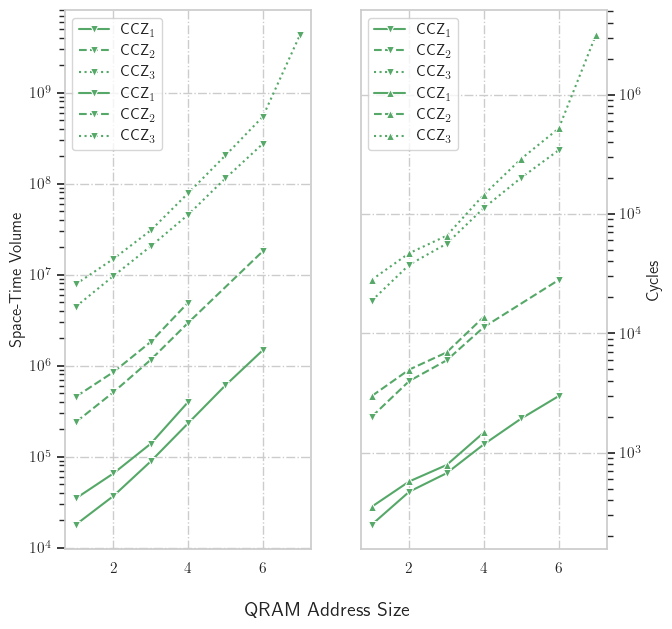

In [12]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


marks = ['', '.', 'x', '*']
linestyles = ['-', '--', ':']

dependent = 'volume'
independent = 'address_size'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

subplot = ax[0]

for line_width in (1, 2):
    for idx, target in enumerate((1, 2, 3)):
        sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_bbg,
                independent,
                dependent,
                distillation=target,
                line_width=line_width
    
            ),
            label=f'CCZ$_{target}$',
            linestyle=linestyles[idx],
            marker='v',
            color=sbs.color_palette()[2]
        )
        
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'
subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data_multi(
            results_bbg,
            independent,
            dependent,
            distillation=target,
            line_width=1
        ),
        label=f'CCZ$_{target}$',
        linestyle=linestyles[idx],
        marker='v',
        color=sbs.color_palette()[2]
    )

for idx, target in enumerate((1, 2, 3)):
    sbs.lineplot(
        ax=subplot,
        **plt_data_multi(
            results_bbg,
            independent,
            dependent,
            distillation=target,
            line_width=2
        ),
        label=f'CCZ$_{target}: 2$',
        linestyle=linestyles[idx],
        marker='^',
        color=sbs.color_palette()[2]
    )
    
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')

fig.supxlabel('QRAM Address Size')
subplot.set_ylabel('Cycles')




#sbs.lineplot(x=results_extern['n_ctrl'], y=results_extern['volume'], label="Toffoli Extern")
#sbs.lineplot(x=results_ccz['n_ctrl'], y=results_ccz['volume'], label='Toffoli Factory', **ccz_style, marker='^')


#plt.title('Toffoli Runtimes for Various QCB Sizes')
#plt.xlabel('C$^{n}$X')
#plt.ylabel('Space-Time Volume')

#plt.yscale('log')
#plt.legend()
#plt.savefig('qram_bb_lw_2.pdf')

In [13]:
def bucket_brigade_gadget_fanout(address_size, line_width, width, height, gates=None, t_factory=None, readout=CNOT, compile=True, BB=None, **compiler_args):
    if gates is None:
        gates = {}
    if t_factory is None:
        t_factory = T_Factory()
   
    if BB is None:
        BB = BB(t_factory)

    def bb(*args):
        dag = BB.instruction(args=args, targs=args)
        return dag

    dag = DAG(Symbol('qram_bucket_brigade', ['query_{i}'.format(i=i) for i in range(address_size)] , ['readout_{i}'.format(i=i) for i in range(line_width)]))

    int_to_bin = lambda x: bin(x)[2:]

    for target_anc in range(line_width):
        anc = int_to_bin(target_anc)
        dag.add_gate(INIT(f'route_root_{anc}'))
    dag.add_gate(INIT(f'ctrl_root'))

    for layer in range(1 << (address_size - 1)):
        layer = int_to_bin(layer)
        dag.add_gate(INIT(f'ctrl_{layer}'))

        for anc in range(line_width):
            dag.add_gate(INIT(f'route_{layer}_{anc}'))

    for layer in range(1 << address_size):
        layer = int_to_bin(layer)
        for addr in range(line_width):
            dag.add_gate(INIT(f'mem_{layer}_{addr}'))


    # Build routing network
    for i in range(address_size):
        dag.add_gate(SWAP(f'query_{i}', f'ctrl_root'))
        if i > 0:
            dag.add_gate(bb(f'ctrl_root', 'route_root', 'route_0_0', 'route_1_0'))
            #print('\t','ROUTE ROOT', i, f'ctrl_root', f'route_root', f'route_1_0')
        else:
            dag.add_gate(SWAP(f'query_{i}', f'ctrl_root'))
            dag.add_gate(bb(f'ctrl_root', 'route_root', 'route_0_0', 'route_1_0'))
            continue

        # Route previous layers
        for layer in range(i - 1):
            if layer > 0:
                for last_layer in range(1 << (layer - 1)):
                    last_layer = int_to_bin(last_layer)
                    dag.add_gate(bb(f'ctrl_{last_layer}', f'route_{last_layer}_0', f'route_{last_layer}0_0', f'route_{last_layer}1_0)'))

        # Control current layer
        for last_layer in range(1 << (i - 1)):
            addr = int_to_bin(last_layer)
            dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_0', f'ctrl_{addr}0', f'ctrl_{addr}0)'))
            #print('\t','CTRL', i, addr , f'ctrl_{addr}', f'route_{addr}', f'ctrl_{addr}1')

    if compile:
        return compile_qcb(dag, height, width,  BB, **compiler_args) 
    else:
        return dag

In [18]:
def bucket_brigade_gadget_readout(address_size, line_width, width, height, gates=None, t_factory=None, readout=CNOT, compile=True, BB=None, **compiler_args):
 
    if gates is None:
        gates = {}
    if t_factory is None:
        t_factory = T_Factory()
   
    if BB is None:
        BB = BB(t_factory) 

    def bb(*args):
        dag = BB.instruction(args=args, targs=args)
        return dag


    dag = DAG(Symbol('qram_bucket_brigade', ['query_{i}'.format(i=i) for i in range(address_size)] , ['readout_{i}'.format(i=i) for i in range(line_width)]))

    int_to_bin = lambda x: bin(x)[2:]


    for target_anc in range(line_width):
        anc = int_to_bin(target_anc)
        dag.add_gate(INIT(f'route_root_{anc}'))
    dag.add_gate(INIT(f'ctrl_root'))

    for layer in range(1 << (address_size - 1)):
        layer = int_to_bin(layer)
        dag.add_gate(INIT(f'ctrl_{layer}'))

        for anc in range(line_width):
            dag.add_gate(INIT(f'route_{layer}_{anc}'))

    for layer in range(1 << address_size):
        layer = int_to_bin(layer)
        for addr in range(line_width):
            dag.add_gate(INIT(f'mem_{layer}_{addr}'))

    # Readout
    #print("READOUT")
    for i in range(1 << (address_size - 1)):
        addr = int_to_bin(i).zfill(address_size - 1)
        for idx in range(line_width):
            dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_{idx}', f'mem_{addr}0_{idx}', f'mem_{addr}1_{idx}'))

    # Back prop routes
    for i in range(address_size - 1, 1, -1): 
        for layer in range(1, i):
            for last_layer in range(1 << (layer - 1)):
                addr = int_to_bin(last_layer)
                for idx in range(line_width):
                    dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_{idx}', f'route_{addr}0', f'route_{addr}1_{idx}'))

    for idx in range(line_width):
        dag.add_gate(bb(f'ctrl_root', f'route_root_{idx}', f'route_0_{idx}', f'route_1_{idx}'))

    # Performing Readout
    for index in range(line_width):
        dag.add_gate(readout(f'mem_0_{index}', f'readout_{index}'))

    for idx in range(line_width):
        dag.add_gate(bb(f'ctrl_root', f'route_root_{idx}', f'route_0_{idx}', f'route_1_{idx}'))

    if compile:
        return compile_qcb(dag, height, width,  BB, **compiler_args) 
    else:
        return dag

In [293]:
qcb = qram_fanout(1, 1, 30, 30, ccz_factory, CSWAP=cswap)

In [ ]:
results = {'distillation':[], 'address_size': [], 'line_width':[], 'height':[], 'runtime':[], 'volume':[], 'delay':[]}

repeats = 5

for distillation, ccz_factory in zip((1,), ccz_factories):
    ccz_toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory)

    bb = BB(ccz_factory, CSWAP=cswap, height=10, width=14)
    while len(bb.dag.physical_externs) < 3: # Rebake until we get something good
        bb = BB(ccz_factory, CSWAP=cswap, height=10, width=14)
    
    for i in range(1, 10):
        for j in range(1, 4):
            for _ in range(repeats):
                try:
                    print(f"\rCompiling: {distillation} : {i} {j}" + " " * 5, end='', flush=True)
                    qcb = qram_fanout(i, j, 48, 48, ccz_factory, CSWAP=cswap)
                    results['distillation'].append(distillation)
                    results['address_size'].append(i)
                    results['line_width'].append(j)
                
                    results['height'].append(qcb_size)
                    results['runtime'].append(qcb.n_cycles())
                    results['volume'].append(qcb.space_time_volume())
                    results['delay'].append(qcb.delays())
                except:
                    pass

results_ccz = results

Compiling: 1 : 8 2     

In [295]:
qcb.space_time_volume()

31877

In [21]:
factory = ccz_factory_l1
ccz_toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=factory)
cswap = partial(CSWAP, Toffoli=ccz_toffoli_gate)


In [22]:
qram_fanout(2, 1, 32, 32, ccz_factory_l1, CSWAP=cswap)

EXTERN: <qram_fanout> : (<query_1>, <query_0>, <readout_0>)

In [23]:
results = {'distillation':[], 'address_size': [], 'line_width':[], 'height':[], 'runtime':[], 'volume':[]}


for distillation, ccz_factory in zip((1, 2, 3), ccz_factories):
    ccz_toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory)
    cswap = partial(CSWAP, Toffoli=ccz_toffoli_gate)
    
    for i in range(1, 10):
        for j in range(1, 4):
            for _ in range(repeats):
                try:
                    print(f"\rCompiling: {distillation} : {i} {j}" + " " * 5, end='', flush=True)
                    qcb = qram_fanout(i, j, 64, 64, ccz_factory, CSWAP=cswap)
                    results['distillation'].append(distillation)
                    results['address_size'].append(i)
                    results['line_width'].append(j)
                
                    results['height'].append(qcb_size)
                    results['runtime'].append(qcb.n_cycles())
                    results['volume'].append(qcb.space_time_volume())
                except:
                    pass

results_fanout = results

Compiling: 3 : 9 3     

In [27]:
results_fanout = {'distillation': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'address_size': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9], 'line_width': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3], 'height': [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32], 'runtime': [38, 62, 87, 72, 118, 169, 109, 182, 268, 182, 270, 463, 311, 457, 838, 566, 1083, 1638, 1096, 2183, 3192, 2189, 4185, 3903, 7314, 10145, 184, 213, 242, 224, 280, 331, 272, 379, 598, 374, 697, 1008, 711, 1304, 2282, 1608, 2849, 4520, 3102, 5483, 8484, 5734, 13335, 26181, 17548, 51433, 146247, 2358, 2392, 2416, 2403, 4696, 7019, 4706, 9355, 14005, 9364, 18686, 25767, 18694, 35111, 63083, 42079, 88746, 126145, 86385, 170447, 254586, 170532, 448190, 670197, 448363, 1302938, 3579478], 'volume': [3521, 4543, 7500, 6733, 14426, 22201, 18731, 36224, 64934, 47593, 96179, 154190, 109926, 215129, 378916, 256698, 594553, 1021584, 661904, 1665378, 3037219, 2054425, 5384290, 6631713, 14091404, 25146336, 31241, 63214, 93793, 95266, 187440, 279434, 222579, 445160, 667105, 485980, 958898, 1428778, 983602, 2008677, 3188853, 2180018, 4435718, 7272955, 4958320, 9947449, 15849930, 10666213, 26047639, 51099761, 34149533, 110377713, 342240205, 685896, 1369864, 2030751, 2113613, 4146746, 6243282, 4843431, 9838842, 14927819, 10711703, 21903860, 32895167, 22995254, 45849860, 73856214, 50203382, 107409348, 172899656, 114982752, 257653733, 404842929, 271738639, 754042741, 1217224959, 809901598, 2697778848, 8402517701]}

{'distillation': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'address_size': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9], 'line_width': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3], 'height': [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 

In [24]:
results.pop('delay')

KeyError: 'delay'

In [20]:
def qram_fanout(address_size,
                line_width,
                height,
                width,
                *externs,
                CSWAP=CSWAP,
                readout=CNOT,
                compile=True,
                **compiler_args):

    dag = DAG(Symbol('qram_fanout', ['query_{i}'.format(i=i) for i in range(address_size)] , ['readout_{i}'.format(i=i) for i in range(line_width)]))

    for target_anc in range(1 << address_size):
        for memory_index in range(line_width):
            dag.add_gate(INIT(f'mem_{target_anc}_{memory_index}'))

    for target_anc in range(address_size):
        dag.add_gate(INIT(f'anc_{target_anc}'))

    # Fanout
    for addr_bit in range(address_size):
        mask = 1 << addr_bit
        target_ancillae = list(filter(lambda x: x % mask == 0, range(1 << address_size)))
        
        dag.add_gate(CNOT(f'query_{addr_bit}', *list(map(
            lambda x: 'anc_{i}'.format(i=x), target_ancillae
            ))))

        for anc_a, anc_b in zip(target_ancillae[::2], target_ancillae[1::2]): 
            for memory_index in range(line_width):
                dag.add_gate(CSWAP(f'anc_{anc_a}', f'mem_{anc_a}_{memory_index}', f'mem_{anc_b}_{memory_index}'))

        dag.add_gate(CNOT(f'query_{addr_bit}', *list(map(
            lambda x: 'anc_{i}'.format(i=x), target_ancillae
            ))))

    # Readout
    for index in range(line_width):
        dag.add_gate(readout(f'mem_0_{index}', f'readout_{index}'))

    # Fan-in
    for addr_bit in range(address_size - 1, -1, -1):
        mask = 1 << addr_bit
        target_ancillae = list(filter(lambda x: x % mask == 0, range(1 << address_size)))
        
        dag.add_gate(CNOT(f'query_{addr_bit}', *list(map(
            lambda x: 'anc_{i}'.format(i=x), target_ancillae
            ))))

        for anc_a, anc_b in zip(target_ancillae[::2], target_ancillae[1::2]): 
            for memory_index in range(line_width):
                dag.add_gate(CSWAP(f'anc_{anc_a}', f'mem_{anc_a}_{memory_index}', f'mem_{anc_b}_{memory_index}'))


        dag.add_gate(CNOT(f'query_{addr_bit}', *list(map(
            lambda x: 'anc_{i}'.format(i=x), target_ancillae
            ))))

    if compile:
        return compile_qcb(dag, height, width, *externs, **compiler_args) 
    return dag



In [ ]:


def mcswap_gadget(height, width, reg_width , *externs, **compiler_arguments):
     
    registers = ['ctrl'] + ['a_{}'.format(i) for i in range(reg_width)] + ['b_{}'.format(i) for i in range(reg_width)]

    dag = DAG(Symbol('mcswap', registers, registers))
    
    for i in range(reg_width):
        dag.add_gate(CSWAP(f'ctrl', f'a_{i}', f'b_{i}'))

    return compile_qcb(dag, height, width, *externs, **compiler_arguments)

def qram_fanout_fanout_gadget(address_size, line_width, height, width, MCSWAP, gates=None, t_factory=None, readout=CNOT, compile=True, **compiler_args):
    if gates is None:
        gates = {}
    if t_factory is None:
        t_factory = T_Factory()

    def mcswap(*args):
        dag = MCSWAP.instruction(args=args, targs=args)
        return dag

    dag = DAG(Symbol('qram_fanout', 
                     ['query_{i}'.format(i=i) for i in range(address_size)] , 
                     ['readout_{i}'.format(i=i) for i in range(line_width)]
                    )
             )

    for target_anc in range(1 << address_size):
        for memory_index in range(line_width):
            dag.add_gate(INIT(f'mem_{target_anc}_{memory_index}'))

    for target_anc in range(address_size):
        dag.add_gate(INIT(f'anc_{target_anc}'))

    # Fanout
    for addr_bit in range(address_size):
        mask = 1 << addr_bit
        target_ancillae = list(filter(lambda x: x % mask == 0, range(1 << address_size)))
        
        dag.add_gate(CNOT(f'query_{addr_bit}', *list(map(
            lambda x: 'anc_{i}'.format(i=x), target_ancillae
            ))))

        for anc_a, anc_b in zip(target_ancillae[::2], target_ancillae[1::2]): 
            dag.add_gate(mcswap(f'anc_{anc_a}', 
                                *['mem_{anc_a}_{memory_index}'.format(anc_a=anc_a, memory_index=i) for i in range(line_width)],
                                *['mem_{anc_b}_{memory_index}'.format(anc_b=anc_b, memory_index=i) for i in range(line_width)]
                                )
                         )

        dag.add_gate(CNOT(f'query_{addr_bit}', *list(map(
            lambda x: 'anc_{i}'.format(i=x), target_ancillae
            ))))

    if compile:
        return compile_qcb(dag, height, width, MCSWAP, **compiler_args) 
    return dag